### Test case LVV-T: Verify implementation of Guider Calibration Data Acquisition
Verify that the  DMS can acquire raw, full-frame exposures from the camera guider sensors during calibration. 

### Requirement:  DMS-REQ-0265
Derived from OSS-REQ-0194:  Calibration Exposures Per Day
The DMS shall acquire raw, full-frame exposures from the camera guider sensors during calibration. 
The DMS shall produce calibration data products for the guide sensors.

#### Discussion
This test is executed a the USDF and queries the consolidated database to inspect the number and type of calibration images acquired by LSSTCam <br>
The guider sensors are  corner detectors in guider mode.  It reads out a small region-of-interest ROI at a fast rate. <br>
It requires a good pointing model. 

Changing from guider mode to imaging mode is difficult

#### Data 
The guiders are on the orner rafts: "R00", "R04", "R40", "R44"
There are guiders on each corner raft: SG0/1: Science Guider 0/1 <br>
Guiders: R00_SG0 (189) ,R00_SG1 (190), R04_SG0 (193) , "R04_SG1 (194), R40_SG0 (197), R40_SG1 (198), R44_SG0 (201), R44_SG1 (202)
Guoder images are archived in multiple locations, and are also in the Butler <br> 


In [1]:
import os
import io
import numpy as np
import astropy.io.fits as pf
from astropy.table import Table
from astropy.io import fits
import pandas as pd
from pathlib import Path
import zipfile
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler

In [2]:
pd.set_option('display.max_columns', None) #all

In [3]:
def to_day_obs_int(dayobs):
    return int(dayobs.replace('-', ''))

In [4]:
# Open a zip file and extract the files
#  MC_O_20250704_000488_R40_SG0_guider.fits
def extract_image_files(filepath):
    images = [] 
    with zipfile.ZipFile(filepath, 'r') as zfile:
        for raft, ccd, detector in config:
            fits_file = Path(Path(filepath).stem + '_' + raft + '_' + ccd +'_guider' + '.fits')
           
            # Read from the fits file into memory
            with zfile.open(str(fits_file), 'r') as file:
                # Read the bytes and wrap in BytesIO to simulate a binary file
                file_data = io.BytesIO(file.read())
                img = fits.getdata(file_data)
                images.append({'image': img, 'label': raft + '_' + ccd})

    return images

In [5]:
# Plot the 8 imagesfor an exposure
def plot_wfs(images):
    fig, axes = plt.subplots(2, 4, figsize=(10, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, image in enumerate(images):
        ax = axes[i]
        img = image['image']
        im = ax.imshow(img, 
                       vmin=np.percentile(img, 1), 
                       vmax=np.percentile(img, 99), 
                       cmap='gray')
        ax.set_title(image['label'])
        ax.axis('off')
        ax.set_aspect('equal')

    
    # Add one shared colorbar
    fig.colorbar(im, ax=axes, shrink=0.8, pad=0.02)
    plt.tight_layout()
    plt.show()

In [6]:
# LSSTCam system integration start and end dates approximate
start_date = "2025-04-15" #first photon
end_date = date_str = (datetime.today() - timedelta(days=5)).strftime('%Y-%m-%d')

day_obs_start_science = to_day_obs_int(start_date) 
day_obs_start_lsstcam = to_day_obs_int(end_date)

In [7]:
# Guider config layout and sensor IDs
config = [['R40', 'SG0', 197], ['R40', 'SG1', 198], 
          ['R44', 'SG0', 201], ['R44', 'SG1', 202], 
          ['R00', 'SG0', 189], ['R00', 'SG1', 190],
          ['R04', 'SG0', 193], ['R04', 'SG1', 194]]
config_df = pd.DataFrame(config, columns=['raft', 'ccd', 'detector'])
gd_ids = ', '.join(str(x) for x in config_df['detector'].tolist())

In [8]:
# Consdb 
consdb = get_tap_service("consdbtap")
assert consdb is not None

In [9]:
# Get all calibration  exposures taken in LSSTCam commissioning for the wavefront sensors only 
# from the start of LSSTCam commissioning to now
instrument = "lsstcam"
table = 'ccdexposure'
query = f'''
SELECT  e.exposure_id, e.day_obs, e.seq_num, e.img_type, e.band, ccde.detector FROM cdb_{instrument}.{table} as ccde
JOIN cdb_{instrument}.exposure as e ON ccde.exposure_id = e.exposure_id
WHERE e.day_obs >= '{day_obs_start_science}' 
AND ccde.detector IN ({gd_ids})
AND e.img_type IN ('bias', 'dark', 'flat', 'science')
AND e.band in ('u','g','r','i','z','y')
ORDER BY e.exposure_id DESC, e.img_type, e.band, ccde.detector ASC
'''
df = consdb.search(query).to_table().to_pandas()

In [10]:
# Random sample of 5
df.sample(5)

,exposure_id,day_obs,seq_num,img_type,band,detector
51436,2025072100415,20250721,415,science,r,197
362907,2025042600016,20250426,16,bias,g,194
121902,2025070900921,20250709,921,dark,z,201
194772,2025062400178,20250624,178,science,r,197
134605,2025070700738,20250707,738,science,i,198


## Stats on the guider images

In [11]:
# Total 
total_images = df['exposure_id'].nunique()
print(f"There are {len(df)} guider images in {total_images} unique science exposures collected from {start_date} throught {end_date}")

There are 387264 guider images in 48408 unique science exposures collected from 2025-04-15 throught 2025-08-16


In [12]:
# Number of wavefront sensors per exposure
n_gds_per_exposure = df.groupby('exposure_id')['detector'].size().reset_index(name='n_gds')
n_gds_per_exposure.sample(5)
missing_gds = n_gds_per_exposure[n_gds_per_exposure['n_gds'] != 8]
assert len(missing_gds)== 0
print(f"All exposures contain 8 gds ccd images")

All exposures contain 8 gds ccd images


## File access to guider images

Guider images are stored in the same files as the wavefront sensor images. Not all files have guider images in them.  

In [13]:
# Path template at USDF where the ancillary data are archived as ZIP files:
filepath_template = ("/sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/{day_obs}/MC_O_{day_obs}_{seq_num:06d}.zip")
s3_filepath_template = ("s3://embargo@rubin-summit/LSSTCam/{day_obs}/MC_O_{day_obs}_{seq_num:06d}/MC_O_{day_obs}_{seq_num:06d}_{raft}_{ccd}_guider.fits")

In [14]:
# This one has no guider files in it
path = "/sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/20250526/MC_O_20250526_000050.zip"
zfile = zipfile.ZipFile(path)
# zfile.infolist()
# Get the entries in the CDB
df[df['exposure_id'] == 2025070400488]

,exposure_id,day_obs,seq_num,img_type,band,detector
153480,2025070400488,20250704,488,science,z,189
153481,2025070400488,20250704,488,science,z,190
153482,2025070400488,20250704,488,science,z,193
153483,2025070400488,20250704,488,science,z,194
153484,2025070400488,20250704,488,science,z,197
153485,2025070400488,20250704,488,science,z,198
153486,2025070400488,20250704,488,science,z,201
153487,2025070400488,20250704,488,science,z,202


In [15]:
sampled_df = pd.concat([
  #  df[df['img_type'] == 'bias'].sample(3),
  #  df[df['img_type'] == 'dark'].sample(3),
   # df[df['img_type'] == 'flat'].sample(3)
    df[df['img_type'] == 'science'].sample(3)
])

Inspecting: /sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/20250521/MC_O_20250521_000174.zip


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

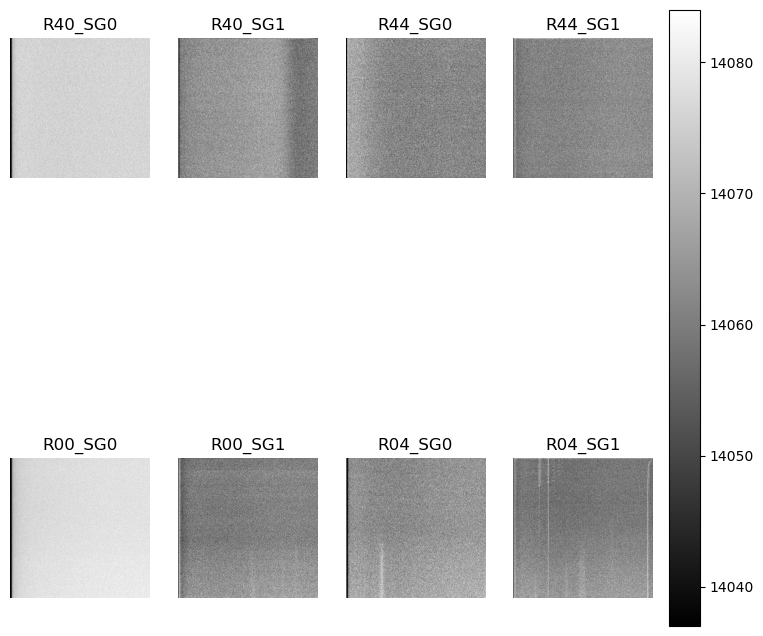

In [16]:
# Take a random few guider exposures and look at the images
exps = df.sample(3)
exps = sampled_df
for _, exp in exps.iterrows():
    file_path = Path(filepath_template.format(
        day_obs=exp['day_obs'],
        seq_num=exp['seq_num']))
    if file_path.exists():
        print(f"Inspecting: {file_path}")
        # Extract images and plot
        gds_images = extract_image_files(file_path)
        plot_wfs(gds_images)
    else:
        print(f"Skipping missing file: {file_path}")

In [ ]:
# DatasetRef(DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), 
#            {instrument: 'LSSTCam', detector: 52, exposure: 2025070400488, band: 'z', day_obs: 20250704, group: '2025-07-05T05:15:40.802', physical_filter: 'z_20'}, 
#            run='LSSTCam/raw/all', id=6fbfc9a8-dae8-5f96-bdf2-77ad21262a54)


## Butler access to guider images

Access the same guider images in the butler

In [ ]:
collections = ["LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202", 'LSSTCam/raw/guider']
butler = Butler("/repo/embargo")

In [ ]:
# ID from Jeff's test 
guider_raw = butler.get('guider_raw', 
                        exposure=2025070400488, 
                        instrument='LSSTCam', detector=194, 
                        collections=COLLECTION)

In [ ]:
len(guider_raw), type(guider_raw)

In [ ]:
# Retrieve all of the images from the guider corresponding to this exposure:
# How many should there be? 50?
guider_raw_imgs = guider_raw.getMaskedImages()
np.shape(guider_raw_imgs)
type(guider_raw_imgs[13])

In [ ]:
psn = guider_raw.getPositions()[0]
psn.getLatitude()

In [ ]:
type(guider_raw_imgs[13])

In [ ]:
# Only the ROI is red out.

afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
display0.mtv(guider_raw_imgs[13])  #.image
plt.title('raw guider image')

plt.tight_layout()
plt.show()

In [ ]:
# Loop over all and extract the guider images
for dayObs, seqNum in df:
    expId = int(f"{dayObs}{seqNum:05d}")



In [ ]:
# Get five recent images
date = to_day_obs_int((datetime.today() - timedelta(days=5)).strftime('%Y-%m-%d'))
query = f'''
SELECT  e.exposure_id, e.day_obs, e.seq_num, e.img_type, e.band, ccde.detector FROM cdb_{instrument}.{table} as ccde
JOIN cdb_{instrument}.exposure as e ON ccde.exposure_id = e.exposure_id
WHERE e.day_obs >= '{date}' 
AND ccde.detector IN ({wfs_ids})
AND e.img_type IN ('science')
ORDER BY e.exposure_id DESC, e.img_type, e.band, ccde.detector ASC
'''
df = consdb.search(query, maxrec=5).to_table().to_pandas()
df